# UNet implementation using pytorch for MRI segmentation
- unet: https://github.com/mateuszbuda/brain-segmentation-pytorch
- pytorch FLOP counter: https://github.com/sovrasov/flops-counter.pytorch

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch 
import torchvision.models as models
import matplotlib.pyplot as plt
from pypapi import events, papi_high as high 
from ptflops import get_model_complexity_info

### Paths

In [3]:
project_dir = '../'
data_dir = '{}data/'.format(project_dir)
results_dir = '{}results/'.format(project_dir)

## Measure FLOPs

### Pre-trained example

In [4]:
init_features = 32
input_size = 256 #i.e. 256x256
n_channels = 3

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=True)
    
macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Computational complexity:       13.74 GMac
Number of parameters:           7.76 M  


In [6]:

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

# fcn_resnet50 = models.segmentation.fcn_resnet50(pretrained=True)
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=True)

vgg19 = models.vgg19(pretrained=True)
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=3, out_channels=1, init_features=64, pretrained=False)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/nikhil/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:13<00:00, 13.5MB/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /home/nikhil/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:16<00:00, 13.5MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/nikhil/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:42<00:00, 13.7MB/s]
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [7]:
model_dict = { 'mobilenet':mobilenet, 'squeezenet':squeezenet, 'alexnet':alexnet, 'googlenet':googlenet, 'resnet18':resnet18, 'fcn_resnet101':fcn_resnet101, 'vgg19':vgg19, 'UNet_tumor':unet}

input_size_list = [64, 256]

In [ ]:
init_features = 'n/a'
n_channels = 3

FLOP_df = pd.DataFrame(columns=['model','input_size','init_features','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0

for name, model in model_dict.items():
    for input_size in input_size_list:
        macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                            print_per_layer_stat=False, verbose=False)

        if name == 'unet_small':
            init_features = 32
        else:
            init_features = 128

        FLOP_df.loc[i] = [name,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
        i = i + 1

FLOP_df.head()

## Add FastSurfer model stats

In [9]:
# input 256: flops: 30913921024.0 params: 1799206
# input 64: flops: 1932120064.0 params: 1799206

# multiplying by 3 since the model is run three times (axial, coronal, sagittal)
FLOP_df.loc[i] = ['FastSurferCNN', 256, init_features, 3] + [3*30913921024.0/1e9, 'GMac', 3*1799206.0/1e6, 'M']
FLOP_df.loc[i+1] = ['FastSurferCNN', 64, init_features, 3] + [3*1932120064.0/1e9, 'GMac', 3*1799206.0/1e6, 'M']

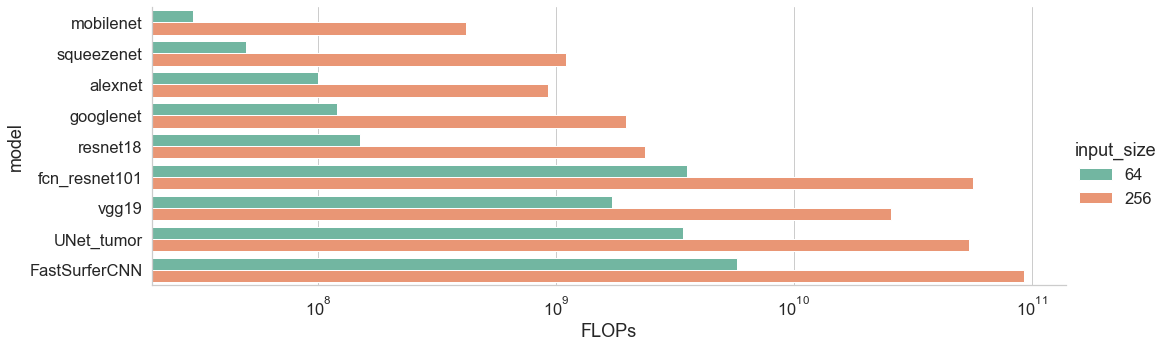

In [10]:
plot_df = FLOP_df.copy()
plot_df[['FLOPs','n_parameters']] = plot_df[['FLOPs','n_parameters']].astype(float)
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'] 
plot_df.loc[plot_df['param_unit']=='k','n_parameters'] = plot_df[plot_df['param_unit']=='k']['n_parameters'].values*1e3
plot_df.loc[plot_df['param_unit']=='M','n_parameters'] = plot_df[plot_df['param_unit']=='M']['n_parameters'].values*1e6

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='model',x='FLOPs', hue='input_size', kind='bar', data=plot_df,palette='Set2',aspect=3)

    g.set(xscale="log") 
    

### plot of FLOPs

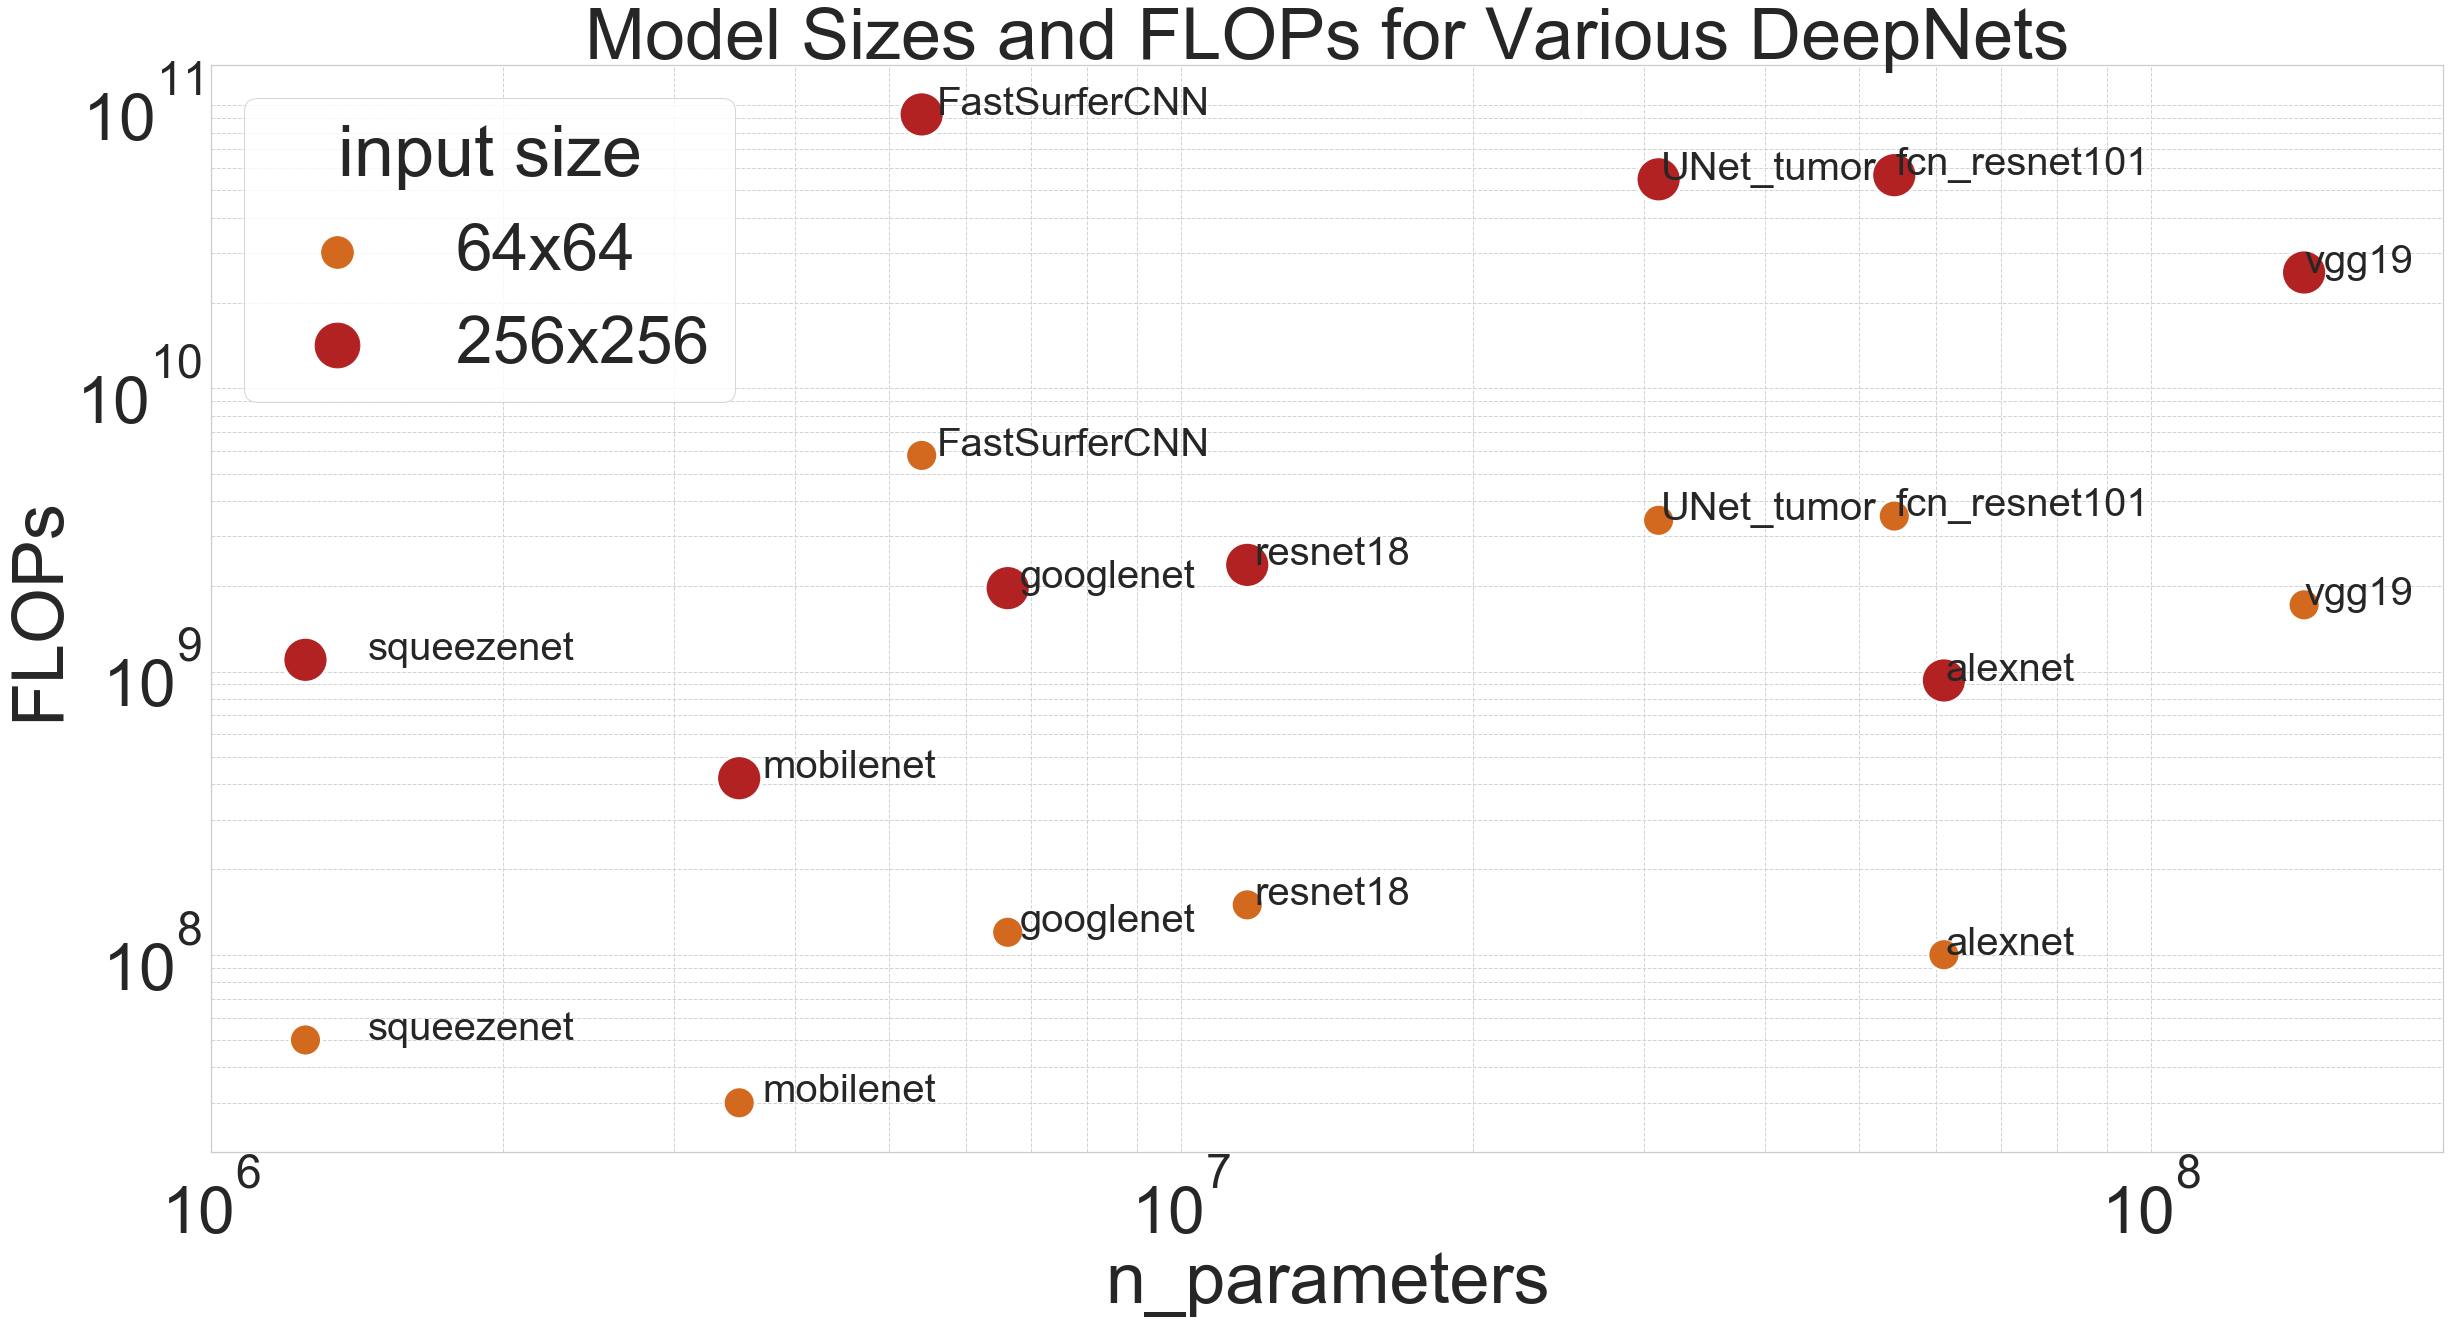

In [11]:
plot_df = FLOP_df.copy()
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'].astype(np.float) 
plot_df['n_parameters'] = 1e6*plot_df['n_parameters'].astype(np.float) 
plot_df['domain'] = 'computer-vision'
plot_df.loc[plot_df['model'].isin(['FastSurferCNN','UNet_tumor']), 'domain'] = 'neuroimaging'

sns.set(font_scale = 6)
palette = ['chocolate','firebrick'] # sns.color_palette("husl", 2) #sns.color_palette("husl", 2)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(40,20),sharex=True,sharey=True)
    g = sns.scatterplot(x='n_parameters',y='FLOPs', hue='input_size', size='input_size', sizes=[1000,2000], data=plot_df, palette=palette,ax=ax1)

    g.set(xscale="log",yscale='log')
    g.grid(True,which="both",ls="--",c='lightgray')  
    # plt.ylabel('compute cost') #'FLOP count -- energy (μJ)
    plt.title('Model Sizes and FLOPs for Various DeepNets')

    g.set(xlim=(1e6, 2e8))
    
    # edit Legend for clarity
    new_labels = ['64x64','256x256']
    ax1.legend(loc='upper left')
    leg = ax1.get_legend()
    leg.set_title('input size')
    for t, l in zip(leg.texts, new_labels): t.set_text(l)

    # add model names as bubble labels
    def label_point(x, y, val, ax, x_shift=200000, y_shift=200000):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+x_shift, point['y']+y_shift, str(point['val']), fontsize=40)

    label_point(plot_df['n_parameters'], plot_df['FLOPs'], plot_df['model'], plt.gca())

## Unet architecture variations (with no-pretrained models)
- input_size
- init_features 

#### FLOPs

In [12]:
model_name = 'unet'
input_size_list = [256] ## vairable input size does not impact model size in fully-conv-nets 
init_features_list = [8, 16, 32, 64]
n_channels_list = [3]

FLOP_df = pd.DataFrame(columns=['model','input_size','init_features','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0

for input_size in input_size_list:
    for init_features in init_features_list:
        for n_channels in n_channels_list:        
            model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=False)
                
            macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                    print_per_layer_stat=False, verbose=False)

            FLOP_df.loc[i] = [model_name,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
            i = i + 1

FLOP_df.head()

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


,model,input_size,init_features,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit
0,unet,256,8,3,0.88,GMac,486.55,k
1,unet,256,16,3,3.46,GMac,1.94,M
2,unet,256,32,3,13.74,GMac,7.76,M
3,unet,256,64,3,54.72,GMac,31.04,M
